# Library

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from torchinfo import summary

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

# Data Information

In [4]:
TRAIN_DIR = '/content/drive/MyDrive/DATASET/Images /Tomatoes vs Apples/train'
TEST_DIR = '/content/drive/MyDrive/DATASET/Images /Tomatoes vs Apples/test'

# Data Preprocessing

## Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-45, 45), transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()

])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## Datasets

In [6]:
def create_datasets(train_dir, test_idr, train_transforms = None, test_transforms = None):
  train_ds = datasets.ImageFolder(train_dir, transform=train_transforms)
  test_ds = datasets.ImageFolder(test_idr, transform=test_transforms)

  return train_ds, test_ds

train_ds , test_ds = create_datasets(TRAIN_DIR, TEST_DIR, train_transforms , test_transforms)

## Data Loader

In [7]:
def create_dataloaders(train_ds, test_ds, batch_size=64):
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  return train_dl, test_dl

train_dl, test_dl = create_dataloaders(train_ds, test_ds)

### Display Images

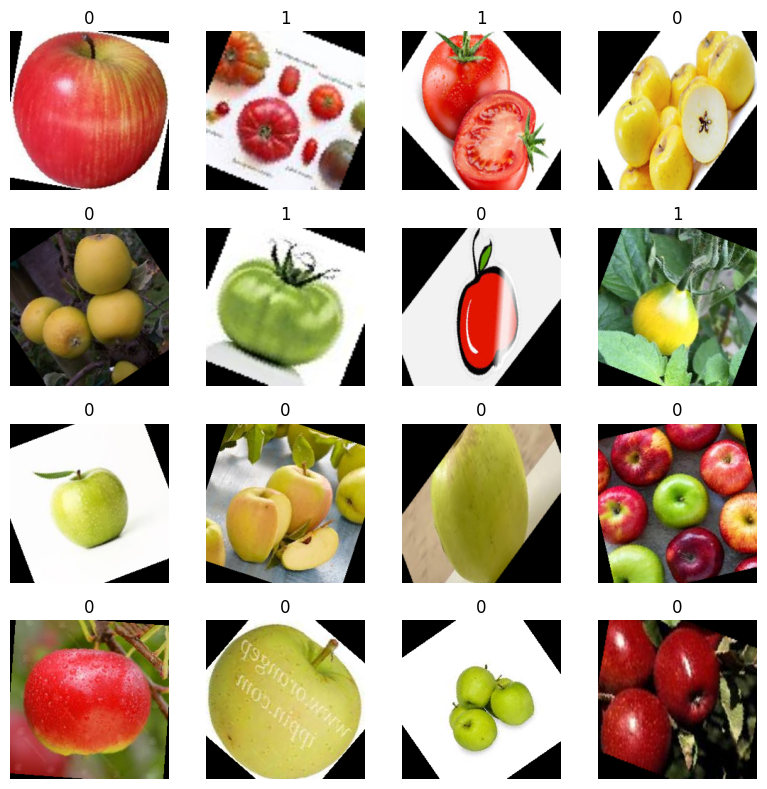

In [8]:
images, labels = next(iter(train_dl))

num_images = len(images)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
  if i < num_images:
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(labels[i].item())
    ax.axis("off")

plt.tight_layout()
plt.show()

# Data Modeling

## Architecture

In [9]:
class CNN(nn.Module):
  def __init__(self, input_channels, hidden_units, output_classes):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels = input_channels, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units // 2, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units // 2, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.AdaptiveAvgPool2d((7, 7))
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 7 * 7,out_features= hidden_units),
      nn.Linear(in_features=hidden_units,out_features=output_classes)
    )

  def forward(self, x):
    x  = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

## Function

In [10]:
def train_one_epoch(dl , model , loss_fn , optmzr , lr_scheduler):
    train_loss , train_acc = 0 , 0
    model.train()
    for batch , (x,y) in enumerate(dl):
        x,y = x.to(device),y.to(device)

        preds = model(x)
        loss = loss_fn(preds , y)
        train_loss += loss.item()

        optmzr.zero_grad()
        loss.backward()
        optmzr.step()

        pred_classes = torch.argmax(torch.softmax(preds,dim = 1) , dim = 1)
        train_acc += torch.sum(pred_classes == y).cpu().item() / len(y)
    lr_scheduler.step()
    return train_acc / len(dl) , train_loss / len(dl)

def validate(dl , model , loss_fn):
    val_loss , val_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for batch , (x,y) in enumerate(dl):
            x, y = x.to(device) , y.to(device)
            preds = model(x)
            loss = loss_fn(preds , y)
            val_loss += loss.item()
            pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)
            val_acc += torch.sum(pred_classes == y).cpu().item() / len(y)
    return val_acc / len(dl) , val_loss / len(dl)

In [11]:
learning_rate = 1e-3
num_epochs = 10

logs = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

model = CNN(input_channels=3, hidden_units=64, output_classes=10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_acc, train_loss = train_one_epoch(train_dl, model, loss_fn, optimizer, scheduler)
    print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")

    val_acc, val_loss = validate(test_dl, model, loss_fn)
    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

    logs['train_acc'].append(train_acc)
    logs['val_acc'].append(val_acc)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)

    print("-" * 30)

print("Training Completed.")

Epoch 1/10
Train Accuracy: 0.4554, Train Loss: 1.5525
Validation Accuracy: 0.4219, Validation Loss: 1.7401
------------------------------
Epoch 2/10
Train Accuracy: 0.4979, Train Loss: 1.0177
Validation Accuracy: 0.4219, Validation Loss: 1.1974
------------------------------
Epoch 3/10
Train Accuracy: 0.5586, Train Loss: 0.7705
Validation Accuracy: 0.6098, Validation Loss: 0.6822
------------------------------
Epoch 4/10
Train Accuracy: 0.4405, Train Loss: 0.7333
Validation Accuracy: 0.5781, Validation Loss: 0.7078
------------------------------
Epoch 5/10
Train Accuracy: 0.5618, Train Loss: 0.7149
Validation Accuracy: 0.4219, Validation Loss: 0.7213
------------------------------
Epoch 6/10
Train Accuracy: 0.5660, Train Loss: 0.6745
Validation Accuracy: 0.4219, Validation Loss: 0.7725
------------------------------
Epoch 7/10
Train Accuracy: 0.5488, Train Loss: 0.6940
Validation Accuracy: 0.4219, Validation Loss: 0.7414
------------------------------
Epoch 8/10
Train Accuracy: 0.5416,

# Model Evaluation

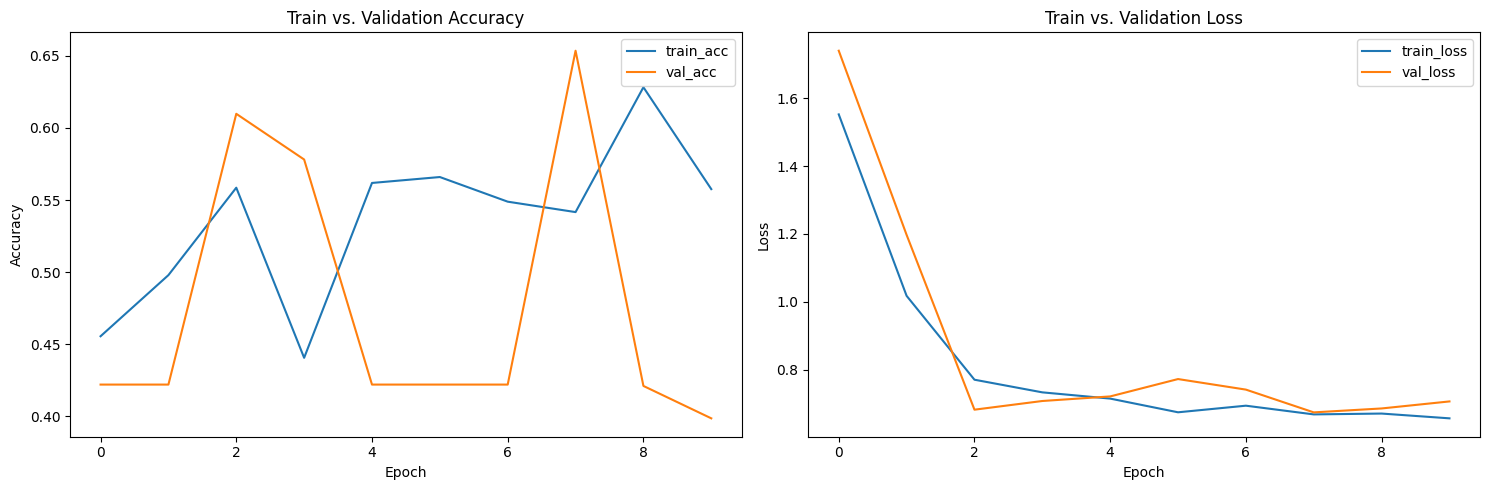

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(logs['train_acc'], label='train_acc')
plt.plot(logs['val_acc'], label='val_acc')
plt.title('Train vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['train_loss'], label='train_loss')
plt.plot(logs['val_loss'], label='val_loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
y_true , y_predicted = [] , []
paths_to_check = []

model.eval()
with torch.inference_mode():
    for batch , (x,y) in enumerate(test_dl):
        x,y = x.to(device),y.to(device)

        preds = model(x)
        pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)

        y_predicted.extend(pred_classes.cpu().numpy())
        y_true.extend(y.cpu().numpy())

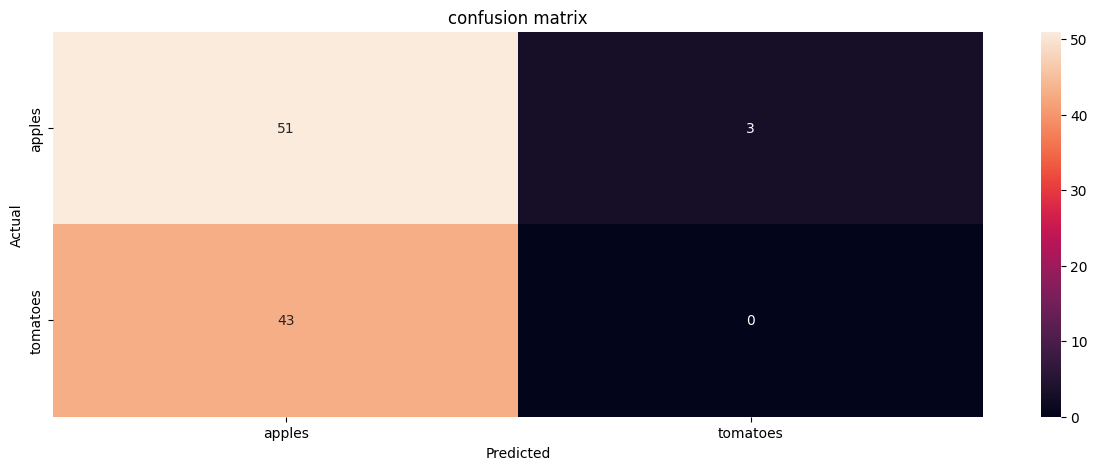

In [14]:
y_true , y_predicted = np.array(y_true) ,np.array(y_predicted)
cm = confusion_matrix(y_true , y_predicted)
label_list = test_ds.classes
plt.figure(figsize = (15 , 5))
ax=plt.subplot()
sns.heatmap(cm , annot = True , fmt='g' ,ax = ax,xticklabels=label_list,yticklabels=label_list)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title("confusion matrix")
plt.show()